In [1]:
#!pip install tensorflow==1.14.0

In [2]:
#!pip install keras==2.2.5

In [3]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [4]:
import gc
import warnings

import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [5]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17163255319734219642
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1426918195
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2197068712700702667
physical_device_desc: "device: 0, name: GeForce MX250, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [7]:
site_id = 9

In [8]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train = df_train[~((df_train.meter_reading == 0) & (df_train.meter.isin([0, 1])))]
df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

del building
gc.collect()

0

In [9]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [10]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [11]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [12]:
cv = 5
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 9 and meter 0
Preparing Site: 9 , meter: 0 , Fold: 1



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 819169 samples, validate on 204793 samples
Epoch 1/21
 - 24s - loss: 1.9480 - val_loss: 0.9951
Epoch 2/21
 - 22s - loss: 1.3210 - val_loss: 0.9780
Epoch 3/21
 - 24s - loss: 1.2995 - val_loss: 0.9640
Epoch 4/21
 - 22s - loss: 1.2782 - val_loss: 0.9480
Epoch 5/21
 - 23s - loss: 1.2576 - val_loss: 0.9309
Epoch 6/21
 - 22s - loss: 1.2396 - val_loss: 0.9214
Epoch 7/21
 - 22s - loss: 1.2239 - val_loss: 0.9108
Epoch 8/21
 - 22s - loss: 1.2101 - val_loss: 0.9062
Epoch 9/21
 - 21s - loss: 1.1957 - val_loss: 0.8942
Epoch 10/21
 - 21s - loss: 1.1828 - val_loss: 0.8823
Epoch 11/21
 - 21s - loss: 1.1714 - val_loss: 0.8771
Epoch 12/21
 - 21s - loss: 1.1609 - val_loss: 0.8801
Epoch 13/21
 - 21s - loss: 1

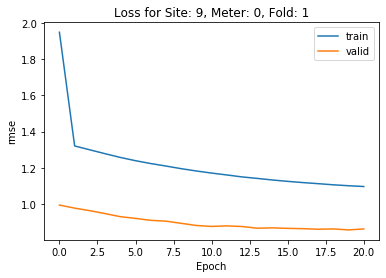

Preparing Site: 9 , meter: 0 , Fold: 2
Train on 819169 samples, validate on 204793 samples
Epoch 1/21
 - 25s - loss: 1.8517 - val_loss: 0.9951
Epoch 2/21
 - 22s - loss: 1.3247 - val_loss: 0.9595
Epoch 3/21
 - 27s - loss: 1.3013 - val_loss: 0.9575
Epoch 4/21
 - 25s - loss: 1.2809 - val_loss: 0.9268
Epoch 5/21
 - 21s - loss: 1.2630 - val_loss: 0.9368
Epoch 6/21
 - 21s - loss: 1.2462 - val_loss: 0.9189
Epoch 7/21
 - 21s - loss: 1.2324 - val_loss: 0.9253
Epoch 8/21
 - 20s - loss: 1.2185 - val_loss: 0.9187
Epoch 9/21
 - 21s - loss: 1.2043 - val_loss: 0.9193
Epoch 10/21
 - 21s - loss: 1.1936 - val_loss: 0.9157
Epoch 11/21
 - 21s - loss: 1.1819 - val_loss: 0.8882
Epoch 12/21
 - 22s - loss: 1.1732 - val_loss: 0.8966
Epoch 13/21
 - 24s - loss: 1.1630 - val_loss: 0.8865
Epoch 14/21
 - 21s - loss: 1.1552 - val_loss: 0.8921
Epoch 15/21
 - 21s - loss: 1.1476 - val_loss: 0.9005
Epoch 16/21
 - 21s - loss: 1.1410 - val_loss: 0.8915
Epoch 17/21
 - 21s - loss: 1.1345 - val_loss: 0.8759
Epoch 18/21
 - 21

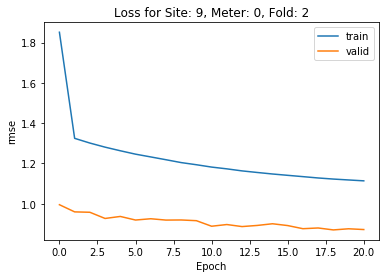

Preparing Site: 9 , meter: 0 , Fold: 3
Train on 819170 samples, validate on 204792 samples
Epoch 1/21
 - 35s - loss: 1.7635 - val_loss: 1.4440
Epoch 2/21
 - 30s - loss: 1.2170 - val_loss: 1.4026
Epoch 3/21
 - 24s - loss: 1.1869 - val_loss: 1.3741
Epoch 4/21
 - 31s - loss: 1.1607 - val_loss: 1.3474
Epoch 5/21
 - 31s - loss: 1.1374 - val_loss: 1.3268
Epoch 6/21
 - 24s - loss: 1.1162 - val_loss: 1.3157
Epoch 7/21
 - 21s - loss: 1.0967 - val_loss: 1.3008
Epoch 8/21
 - 23s - loss: 1.0791 - val_loss: 1.2878
Epoch 9/21
 - 24s - loss: 1.0622 - val_loss: 1.2817
Epoch 10/21
 - 24s - loss: 1.0475 - val_loss: 1.2754
Epoch 11/21
 - 31s - loss: 1.0337 - val_loss: 1.2810
Epoch 12/21
 - 33s - loss: 1.0221 - val_loss: 1.2659
Epoch 13/21
 - 26s - loss: 1.0111 - val_loss: 1.2704
Epoch 14/21
 - 31s - loss: 1.0014 - val_loss: 1.2710
Epoch 15/21
 - 35s - loss: 0.9920 - val_loss: 1.2674
Epoch 16/21
 - 32s - loss: 0.9834 - val_loss: 1.2640
Epoch 17/21
 - 33s - loss: 0.9760 - val_loss: 1.2725
Epoch 18/21
 - 39

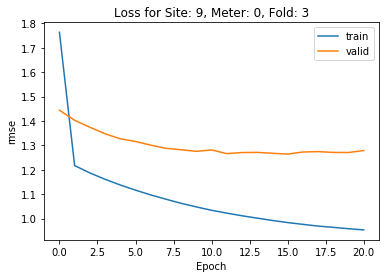

Preparing Site: 9 , meter: 0 , Fold: 4
Train on 819170 samples, validate on 204792 samples
Epoch 1/21
 - 29s - loss: 1.8692 - val_loss: 1.1464
Epoch 2/21
 - 21s - loss: 1.3224 - val_loss: 1.1111
Epoch 3/21
 - 26s - loss: 1.2981 - val_loss: 1.0946
Epoch 4/21
 - 26s - loss: 1.2779 - val_loss: 1.0420
Epoch 5/21
 - 25s - loss: 1.2584 - val_loss: 1.0415
Epoch 6/21
 - 25s - loss: 1.2423 - val_loss: 1.0304
Epoch 7/21
 - 25s - loss: 1.2254 - val_loss: 1.0224
Epoch 8/21
 - 25s - loss: 1.2106 - val_loss: 0.9989
Epoch 9/21
 - 25s - loss: 1.1987 - val_loss: 0.9873
Epoch 10/21
 - 22s - loss: 1.1866 - val_loss: 0.9779
Epoch 11/21
 - 28s - loss: 1.1755 - val_loss: 0.9801
Epoch 12/21
 - 24s - loss: 1.1643 - val_loss: 0.9639
Epoch 13/21
 - 24s - loss: 1.1548 - val_loss: 0.9710
Epoch 14/21
 - 22s - loss: 1.1463 - val_loss: 0.9729
Epoch 15/21
 - 21s - loss: 1.1379 - val_loss: 0.9800
Epoch 16/21
 - 21s - loss: 1.1303 - val_loss: 0.9805
Epoch 17/21
 - 21s - loss: 1.1243 - val_loss: 0.9786
Epoch 18/21
 - 23

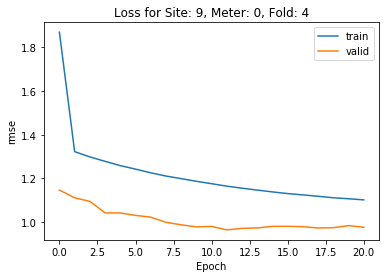

Preparing Site: 9 , meter: 0 , Fold: 5
Train on 819170 samples, validate on 204792 samples
Epoch 1/21
 - 23s - loss: 1.9017 - val_loss: 0.8884
Epoch 2/21
 - 21s - loss: 1.3665 - val_loss: 0.8666
Epoch 3/21
 - 22s - loss: 1.3438 - val_loss: 0.8308
Epoch 4/21
 - 21s - loss: 1.3243 - val_loss: 0.8085
Epoch 5/21
 - 21s - loss: 1.3056 - val_loss: 0.7985
Epoch 6/21
 - 21s - loss: 1.2889 - val_loss: 0.7883
Epoch 7/21
 - 21s - loss: 1.2746 - val_loss: 0.7797
Epoch 8/21
 - 21s - loss: 1.2606 - val_loss: 0.7848
Epoch 9/21
 - 22s - loss: 1.2465 - val_loss: 0.7735
Epoch 10/21
 - 22s - loss: 1.2340 - val_loss: 0.7767
Epoch 11/21
 - 22s - loss: 1.2228 - val_loss: 0.7767
Epoch 12/21
 - 24s - loss: 1.2123 - val_loss: 0.7572
Epoch 13/21
 - 22s - loss: 1.2027 - val_loss: 0.7619
Epoch 14/21
 - 22s - loss: 1.1937 - val_loss: 0.7745
Epoch 15/21
 - 21s - loss: 1.1856 - val_loss: 0.7848
Epoch 16/21
 - 21s - loss: 1.1773 - val_loss: 0.7811
Epoch 17/21
 - 23s - loss: 1.1708 - val_loss: 0.7820
Epoch 18/21
 - 22

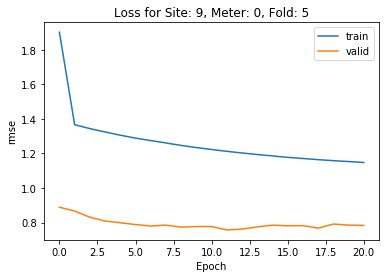


CV RMSE for Site: 9 and Meter: 0 is 1.1166431459658102

CV RMSE for Site: 9 is 1.1166431459658102


In [13]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(256, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(64, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(8, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=21, batch_size=500, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [14]:
df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)